In [1]:
import mbo_utilities.lazy_array
!uv pip install jupyterlab-vim

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Intel(R) Graphics (RPL-P),IntegratedGPU,Vulkan,Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319
❗ limited,"llvmpipe (LLVM 15.0.7, 256 bits)",CPU,Vulkan,Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319 (LLVM 15.0.7)
❌,Mesa Intel(R) Graphics (RPL-P),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 24.2.8-1~bpo12+1pop1~1744225826~22.04~b077665


Sourcing .zshenv...
Using Python 3.12.10 environment at: /home/flynn/repos/work/mbo_utilities/.venv
Resolved 92 packages in 220ms                                        
Installed 1 package in 5ms.4                                
 + jupyterlab-vim==4.1.4


In [10]:
%load_ext autoreload
%autoreload 2

import mbo_utilities as mbo
import fastplotlib as fpl
import tifffile
import numpy as np
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def find_si_rois(file):
    """
    Find the ROIs in the current ScanImage session.

    Returns
    -------
    list
        List of ROI names.
    """
    with tifffile.TiffFile(file, mode="r") as _tf:
        if is_raw_scanimage(file):
            si_metadata = _tf.scanimage_metadata
        if has_mbo_metadata(file):
            si_metadata = _tf.shaped_metadata[0]["si"]
        rois = si_metadata["RoiGroups"]["imagingRoiGroup"]["rois"]
    return rois

import matplotlib.pyplot as plt
Path("/tmp/01").mkdir(exist_ok=True,)

data = mbo.imread(
    r"/home/flynn/lbm_data/raw"
)

Initializing MBO Scan with parameters:
roi: None, fix_phase: True, phasecorr_method: frame, border: 3, upsample: 5, max_offset: 4


Generating combined kerchunk reference for 2 files…
Combined kerchunk reference written to /home/flynn/lbm_data/raw/combined_refs.json
Raw tiff fully read.


In [19]:
data.roi = 2
data.fix_phase = False

In [ ]:
iw = fpl.ImageWidget(data)
iw.show()

In [21]:
iw.close()

In [23]:
mbo.imwrite(data, "/home/flynn/lbm_data/temp", planes=[10])

Final shape: (238, 224, 448) (nt, height, width)
Total chunks to save: 3 (target chunk size: 20.00 MB)


2


Saving plane :   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
corr = tifffile.imread("/home/flynn/lbm_data/temp/roi2/plane10.tif")

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
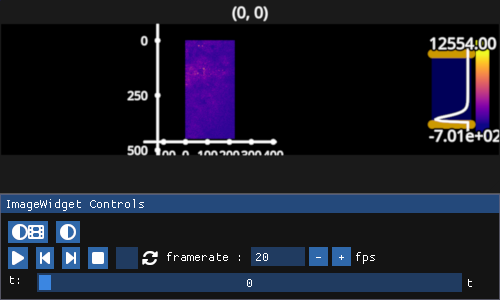

In [26]:
iw = fpl.ImageWidget(corr)
iw.show()

In [13]:
data.output_xslices, data.output_yslices, data.xslices, data.yslices

([slice(0, 224, None), slice(224, 448, None)],
 [slice(0, 448, None), slice(0, 448, None)],
 [slice(0, 224, None), slice(0, 224, None)],
 [slice(0, 448, None), slice(464, 912, None)])

In [14]:
data.output_xslices[0], data.output_xslices[1]

(slice(0, 224, None), slice(224, 448, None))

In [ ]:
iw = fpl.ImageWidget(data, figure_kwargs={"size": (550, 550)})
iw.show()